# Amazon Bedrock - Latency Benchmark Tool
This notebook contains a set of tools to benchmark inference latency for Foundation Models available in Amazon Bedrock.

You can evaluate latency for different scenarios such as comparison between use cases, regions, and models, including models from 3rd-party platforms like OpenAI's GPT-4.

To run this notebook you will need to have the appropriate access to Amazon Bedrock, and previously enabled the models from the Amazon Bedrock Console.

## Examples included in this notebook
1. [Use Case Comparison](#uc-compare) - Compare the latency of a given model across different LLM use cases (e.g., Summarization and classification).
2. [Region Comparison](#region-compare) - Comparing latency between two different models.
3. [Model Comparison](#model-compare) - Comparing the latency of a given model across different AWS regions.

### Install needed dependencies
Note: This notebook requires a basic Python 3 environment (e.g, `Base Python 3.0` in SageMaker Studio Notebooks)

### Store 3rd-Party API Keys
If comparing to LLMs on OpenAI, store your API key in AWS Secrets Manager, in the same region, in the following format:
- Key: `openai`
- Value: `sk-k....`
- Secret Name: `models`

In [20]:
!pip install --quiet --upgrade pip
!pip install --quiet --upgrade boto3 awscli matplotlib numpy pandas anthropic openai

In [3]:
%load_ext autoreload
%autoreload 2
from utils.utils import benchmark, create_prompt, execute_benchmark, get_cached_client, post_iteration, graph_scenarios_boxplot
import matplotlib.pyplot as plt

## Scenario keys and configurations

Each scenario is a dictionary with latency relevant keys:

| Key | Definition |
|-|-|
| `model_id` | The Bedrock model_id (like `anthropic.claude-v2`) or OpenAI model name (like `gpt-4-1106-preview`) to test. Smaller models are likely faster. Currently only Anthropic models are supported. |
| `in_tokens` | The number of tokens to feed to the model (input context length). The range depends on the model_id. For example: 40 - 100K for Claude-2. |
| `out_tokens` | The number of tokens for the model to generate. Range: 1 - 8191. |
| `region` | The AWS region to invoke Bedrock in. This can affect network latency depending on client location. |
| `stream` | True&#124;False - A streaming response starts returning tokens to the client as they are generated, instead of waiting before returning the complete responses. This should be True for interactive use cases.|
| `name` | A human readable name for the scenario (will appear in reports and graphs). |

Each scenario also has a benchmark configuration you can modify:

| Key | Definition |
|-|-|
| `invocations_per_scenario` | The number of times to benchmark each scenario. This is important in measuring variance and average response time across a long duration. |
| `sleep_between_invocations` | Seconds to sleep between each invocation. (0 is no sleep). Sleeping between invocation can help you measure across longer periods of time, and/or avoid throttling.|

## Example 1. LLM Use Case Comparison
<a id="uc-compare"></a>
Compare the latency of a given model across different LLM use cases. 
For example Summarization and classification:
- A Summarization use case is typically characterized by a lengthy input and a much shorter response. We used 2000 `in_tokens` and 200 `out_tokens`.
- A Classification use case is typically  characterized by a lengthy/medium input size and is single returned class (token).
We used 400 `in_tokens` and a single `out_tokens`.

Feel free to change the scenarios to better match your own use cases.

In [4]:
use_cases_scenarios = [
            {
                'model_id'    : 'anthropic.claude-v2',
                'in_tokens'  : 2000,
                'out_tokens' : 200,
                'region'     : 'us-east-1',
                'stream' : True,
                'name' : f'Summarization. in=2000, out=200',
            },
            {
                'model_id'    : 'anthropic.claude-v2',
                'in_tokens' : 400,
                'out_tokens' : 1,
                'region'     : 'us-east-1',
                'stream' : True,
                'name' : f'Classification. in=400, out=1',
            },
]

scenario_config = {
    "invocations_per_scenario" : 2,
    "sleep_between_invocations": 5
}

In [8]:
scenarios = execute_benchmark(use_cases_scenarios, scenario_config, early_break = False)

Scenario: [Summarization. in=2000, out=200, invocation: { 'time-to-first-token': 2.87,
  'time-to-last-token': 7.62,
  'timestamp_iso': '2023-11-22T16:35:04Z'}
Sleeping for 5 seconds.
Scenario: [Summarization. in=2000, out=200, invocation: { 'time-to-first-token': 2.29,
  'time-to-last-token': 6.08,
  'timestamp_iso': '2023-11-22T16:35:17Z'}
Scenario: [Classification. in=400, out=1, invocation: { 'time-to-first-token': 13.87,
  'time-to-last-token': 13.88,
  'timestamp_iso': '2023-11-22T16:35:23Z'}
Sleeping for 5 seconds.
Scenario: [Classification. in=400, out=1, invocation: { 'time-to-first-token': 0.88,
  'time-to-last-token': 0.89,
  'timestamp_iso': '2023-11-22T16:35:42Z'}


#### Analyze results 
The results show should show that summarization has a higher latency than classification due to the smaller number of input and output tokens.  
Note: Learn more on how to read boxplots [here](https://builtin.com/data-science/boxplot)

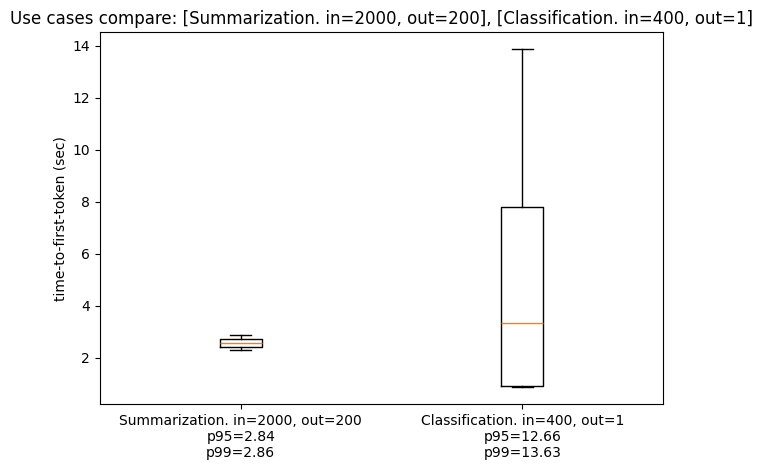

In [9]:
graph_scenarios_boxplot(scenarios=scenarios, title=f"Use cases compare: [{scenarios[0]['name']}], [{scenarios[1]['name']}]")

## Example 2. Model Comparison
<a id="model-compare"></a>
Here we'll be comparing the latency of two different models: `anthropic.claude-v2` and `anthropic.claude-instant-v1`. We expect `anthropic.claude-v2` to be slower as it is a bigger, more capable and more expensive model.

In [28]:
model_compare_scenarios = [
            {
                'model_id'    : 'anthropic.claude-v2', # <---- changed
                'in_tokens'  : 200,
                'out_tokens' : 50,
                'region'     : 'us-east-1',
                'stream' : False,
                'name' : f'claude-v2. in=200, out=50',
            },
            {
                'model_id'    : 'anthropic.claude-instant-v1', # <---- changed
                'in_tokens' : 200,
                'out_tokens' : 50,
                'region'     : 'us-east-1',
                'stream' : False,
                'name' : f'claude-instant-v1. in=200, out=50',
            },
            {
                'model_id'    : 'gpt-4-1106-preview', # <---- changed
                'in_tokens' : 200,
                'out_tokens' : 50,
                'stream' : False,
                'name' : f'gpt-4-1106-preview. in=200, out=50',
            }
]

scenario_config = {
    "invocations_per_scenario" : 2,
    "sleep_between_invocations": 5
}

In [29]:
scenarios = execute_benchmark(model_compare_scenarios, scenario_config)

module 'botocore' has no attribute 'config'
Error while processing scenario: claude-v2. in=200, out=50.
module 'botocore' has no attribute 'config'
Error while processing scenario: claude-v2. in=200, out=50.
module 'botocore' has no attribute 'config'
Error while processing scenario: claude-instant-v1. in=200, out=50.
module 'botocore' has no attribute 'config'
Error while processing scenario: claude-instant-v1. in=200, out=50.


You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

Error while processing scenario: gpt-4-1106-preview. in=200, out=50.


You tried to access openai.Complet

### Results
Results show show that claude-instant-v1 is faster than Claude-v2.

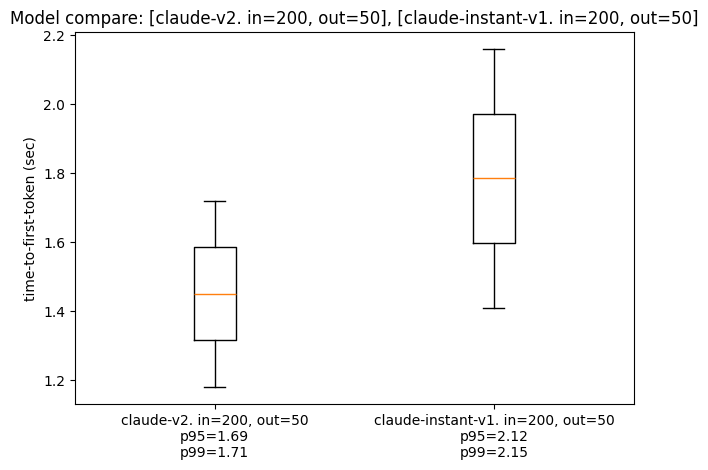

In [12]:
graph_scenarios_boxplot(scenarios=scenarios, title=f"Model compare: [{scenarios[0]['name']}], [{scenarios[1]['name']}]")

## Example 3. Region Comparison
<a id="region-compare"></a>
Here we'll be comparing the latency of a given model_id across three different AWS regions. Different regions resides in different timezone, and the load on each region can depend on the time of day.
> **🚨 ALERT 🚨** Remember to enable the models in **all regions** you wish to test. 
You can learn how to manage model access in the following [page](https://docs.aws.amazon.com/bedrock/latest/userguide/model-access.html#manage-model-access).


In [14]:
region_compare_scenarios = [
            {
                'model_id'    : 'anthropic.claude-instant-v1',
                'in_tokens'  : 200,
                'out_tokens' : 50,
                'region'     : 'us-east-1', # <---- changed
                'stream' : False,
                'name' : f'us-east-1',
            },
            {
                'model_id'    : 'anthropic.claude-instant-v1',
                'in_tokens' : 200,
                'out_tokens' : 50,
                'region'     : 'us-west-2', # <---- changed
                'stream' : False,
                'name' : f'us-west-2',
            }
            # {
            #     'model_id'    : 'anthropic.claude-instant-v1',
            #     'in_tokens' : 200,
            #     'out_tokens' : 50,
            #     'region'     : 'eu-central-1', # <---- changed
            #     'stream' : True,
            #     'name' : f'eu-central-1',
            # },
]

scenario_config = {
    "invocations_per_scenario" : 2,
    "sleep_between_invocations": 5
}

In [15]:
scenarios = execute_benchmark(region_compare_scenarios, scenario_config, early_break = False)

Scenario: [us-east-1, invocation: { 'time-to-first-token': 1.02,
  'time-to-last-token': 1.02,
  'timestamp_iso': '2023-11-22T16:40:01Z'}
Sleeping for 5 seconds.
Scenario: [us-east-1, invocation: { 'time-to-first-token': 1.58,
  'time-to-last-token': 1.58,
  'timestamp_iso': '2023-11-22T16:40:08Z'}
Scenario: [us-west-2, invocation: { 'time-to-first-token': 1.01,
  'time-to-last-token': 1.01,
  'timestamp_iso': '2023-11-22T16:40:10Z'}
Sleeping for 5 seconds.
Scenario: [us-west-2, invocation: { 'time-to-first-token': 1.0,
  'time-to-last-token': 1.0,
  'timestamp_iso': '2023-11-22T16:40:16Z'}


### Results
We don't apriori expect a particular region to be faster than others in a significant way. 

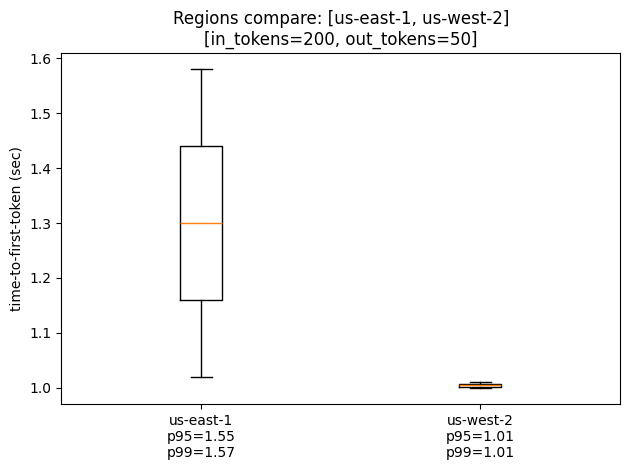

In [19]:
# graph_scenarios_boxplot(
#     scenarios=scenarios, 
#     title=f"Regions compare: [{scenarios[0]['name']}, {scenarios[1]['name']}, {scenarios[2]['name']}]" +
#     f"\n[in_tokens={scenarios[0]['in_tokens']}, out_tokens={scenarios[0]['out_tokens']}]"
# )

graph_scenarios_boxplot(
    scenarios=scenarios, 
    title=f"Regions compare: [{scenarios[0]['name']}, {scenarios[1]['name']}]" +
    f"\n[in_tokens={scenarios[0]['in_tokens']}, out_tokens={scenarios[0]['out_tokens']}]"
)

# Done